In [1]:
import os

from autocvd import autocvd
autocvd(num_gpus = 1)
# os.environ['CUDA_VISIBLE_DEVICES'] = '4'  # Set the GPU to use, if available


import blackjax
from blackjax.progress_bar import gen_scan_fn

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding
from jax.scipy.stats import gaussian_kde
# jax.config.update("jax_enable_x64", True)  # Enable 64-bit precision

import matplotlib.pyplot as plt


import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})



In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  
# code_units = CodeUnits(code_length, code_mass, G=G)  # default values


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 500, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)
#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,return_snapshots=True,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
# pos_com_final = jnp.array([[12.4, 1.5, 7.1]]) * u.kpc.to(code_units.code_length)
# vel_com_final = jnp.array([[107.0, -243.0, -105.0]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1].copy()
s = projection_on_GD1(final_state, code_units=code_units,)
target_stream = s



# Gradient ascend 2 params

In [3]:
# Gradient on the loss for 2 parameters
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,
                         N_particles = 1000, )
config_com = config_com._replace(return_snapshots=False,)

config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)
stream_target = s


@jit
def time_integration_NFWM_tend_grad(Mvir, t_end, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params = new_params._replace(
                t_end=t_end,  # Update the t_end parameter
                )
    
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    
    #we also update the t_end parameter for the center of mass
    new_params_com = new_params_com._replace(
                t_end=-t_end,  # Update the t_end parameter for the center of mass
                )
    
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.00001])

    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        return jnp.sum(logL_values)
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)

In [4]:
bounds_mass = jnp.log10(np.array([1e11, 1e12]) * u.Msun.to(code_units.code_mass)) # in code units
bound_time = jnp.log10(np.array([5e-3, 5]) * u.Gyr.to(code_units.code_time)) # in code units

@jit 
def normalize_Mvir_and_t_end(Mvir_and_t_end):
    # Mvir, t_end = Mvir_and_t_end
    Mvir, t_end = jnp.log10(Mvir_and_t_end)
    # Normalize Mvir to [-1, 1]
    Mvir_norm = (Mvir - bounds_mass[0]) / (bounds_mass[1] - bounds_mass[0])
    # Normalize t_end to [-1, 1]
    t_end_norm = (t_end - bound_time[0]) / (bound_time[1] - bound_time[0]) 
    return jnp.array([Mvir_norm, t_end_norm])

@jit
def de_normalize_Mvir_and_t_end(Mvir_and_t_end_norm):
    Mvir_norm, t_end_norm = Mvir_and_t_end_norm
    # De-normalize Mvir to original scale
    Mvir = Mvir_norm * (bounds_mass[1] - bounds_mass[0]) + bounds_mass[0]
    Mvir = jnp.power(10, Mvir)
    # De-normalize t_end to original scale
    t_end = t_end_norm * (bound_time[1] - bound_time[0]) + bound_time[0]
    t_end = jnp.power(10, t_end)
    return jnp.array([Mvir, t_end])

    
@jit
def time_integration_for_gradient_descend(Mvir_and_t_end, key):
    # Mvir, t_end = de_normalize_Mvir_and_t_end(Mvir_and_t_end)
    Mvir, t_end = Mvir_and_t_end
    Mvir = 10**Mvir  # Convert back to original scale
    t_end = 10**t_end
    return (time_integration_NFWM_tend_grad)(Mvir, t_end, key)

In [5]:
# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = (params.NFW_params.Mvir*(3/4) * u.Msun).to(code_units.code_mass).value
t_end = (params.t_end * (5/4) * u.Gyr).to(code_units.code_time).value  # Example: 25% increase in t_end
key = 0
loss, grad = jax.value_and_grad(lambda Mvir, t_end, key: time_integration_NFWM_tend_grad(jnp.log10(Mvir), jnp.log10(t_end), key), argnums=(0,1))(Mvir, t_end, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  

n_sim = 10

# M_tot_values = jnp.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(8/4), n_sim-1) # Adjust range based on expected values
# t_end_values = jnp.linspace(params.t_end * (1/4), params.t_end * (8/4), n_sim-1)   # Adjust range based on expected timescales

M_tot_values = jax.random.uniform(random.PRNGKey(0), shape=(n_sim,), minval=params.NFW_params.Mvir*(1/4), maxval=params.NFW_params.Mvir*(8/4))  # Random values in the range
t_end_values = jax.random.uniform(random.PRNGKey(0), shape=(n_sim,), minval=params.t_end * (1/4), maxval=params.t_end * (8/4))  # Random values in the range

# M_tot_values = jnp.concatenate([M_tot_values, jnp.array([params.NFW_params.Mvir])])  # Append the true Mvir value
# t_end_values = jnp.concatenate([t_end_values, jnp.array([params.t_end])])  # Append the true t_end value
# Ensure both arrays are sorted
M_tot_values = jnp.sort(M_tot_values)
t_end_values = jnp.sort(t_end_values)


# Create a meshgrid
M_tot_grid, t_end_grid,  = jnp.meshgrid(M_tot_values, t_end_values, indexing="ij")

# Flatten the grid for vectorized computation
Mvir_flat = M_tot_grid.flatten()
t_end_flat = t_end_grid.flatten()
keys_flat = jnp.arange(len(Mvir_flat))  # Create a flat array of keys

mesh = Mesh(np.array(jax.devices()), ("i",))
Mvir_sharded = jax.device_put(Mvir_flat, NamedSharding(mesh, PartitionSpec("i")))
t_end_sharded = jax.device_put(t_end_flat, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys_flat, NamedSharding(mesh, PartitionSpec("i")))


@jit
def time_integration_for_laxmap(input):
    Mvir, t_end, key = input
    return jax.value_and_grad(time_integration_for_gradient_descend,)((jnp.log10(Mvir), jnp.log10(t_end)), key)

loss, grad = jax.lax.map(f=time_integration_for_laxmap, 
                         xs=(Mvir_sharded, t_end_sharded, keys_sharded), 
                         batch_size=3)


Gradient of the total mass of the Mvir of NFW:
 (Array(2.2510722e-08, dtype=float32), Array(-30520.828, dtype=float32))
Loss:
 -59679.69


Minimum loss: -57698.2578125, Mvir: 833660059648.0, t_end: 5.7252516746521
Maximum loss: -32541.2421875, Mvir: 467485753344.0, t_end: 3.2105093002319336


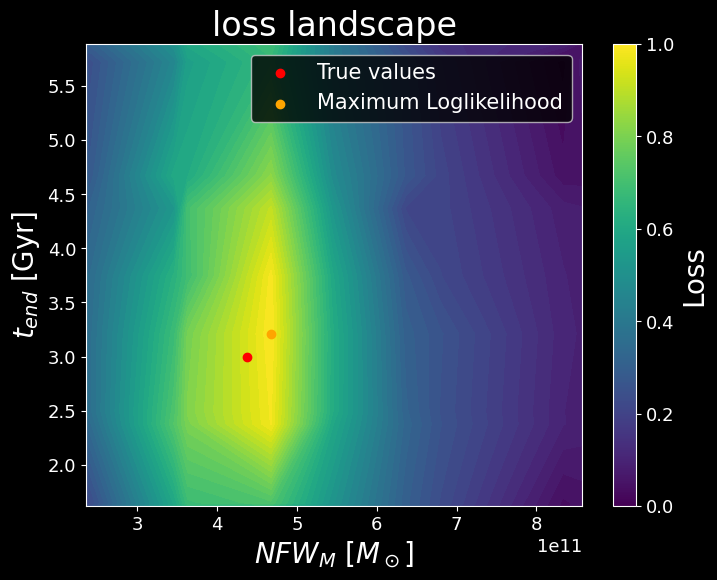

In [6]:
loss_min, min_index = jnp.min(loss), jnp.argmin(loss)
Mvir_min = Mvir_flat[jnp.argmin(loss)]
t_end_min = t_end_flat[jnp.argmin(loss)]
print(f"Minimum loss: {loss_min}, Mvir: {Mvir_min * code_units.code_mass.to(u.Msun)}, t_end: {t_end_min * code_units.code_time.to(u.Gyr)}")
loss = loss.reshape(M_tot_grid.shape)

loss_max, max_index = jnp.max(loss), jnp.argmax(loss)
Mvir_max = M_tot_grid.flatten()[max_index]
t_end_max = t_end_grid.flatten()[max_index]
print(f"Maximum loss: {loss_max}, Mvir: {Mvir_max * code_units.code_mass.to(u.Msun)}, t_end: {t_end_max * code_units.code_time.to(u.Gyr)}")


# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(M_tot_values*code_units.code_mass.to(u.Msun), t_end_values*code_units.code_time.to(u.Gyr), loss.T, levels=50, cmap="viridis")
plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), params.t_end * code_units.code_time.to(u.Gyr),color="red", label="True values")
# plt.scatter(Mvir_min * code_units.code_mass.to(u.Msun), t_end_min * code_units.code_time.to(u.Gyr), color="blue", label="Minimum loss")
plt.scatter(Mvir_max * code_units.code_mass.to(u.Msun), t_end_max * code_units.code_time.to(u.Gyr), color="orange", label="Maximum Loglikelihood")
plt.colorbar(label="Loss")
plt.xlabel("$NFW_{M}$ [$M_\odot$]")
plt.ylabel("$t_{end}$ [Gyr]")
plt.title("loss landscape")
plt.legend()

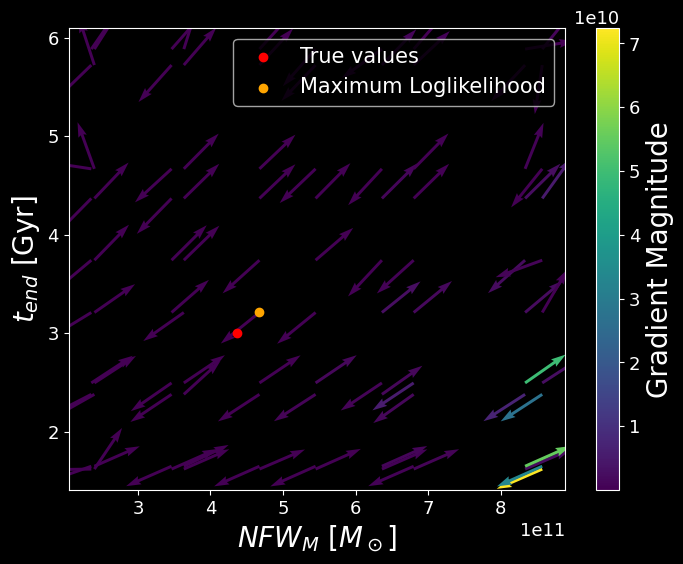

In [7]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
quiver = ax.quiver(M_tot_values * code_units.code_mass.to(u.Msun),
           t_end_values * code_units.code_time.to(u.Gyr),
           grad[0].reshape(M_tot_grid.shape)/jnp.sqrt(grad[0]**2 + grad[1]**2).reshape(M_tot_grid.shape),
           grad[1].reshape(M_tot_grid.shape)/jnp.sqrt(grad[0]**2 + grad[1]**2).reshape(M_tot_grid.shape),
           jnp.sqrt(grad[0]**2 + grad[1]**2).reshape(M_tot_grid.shape),
           scale=10, alpha=1, cmap='viridis')
ax.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), 
            params.t_end * code_units.code_time.to(u.Gyr), color="red", label="True values")
# ax.scatter(Mvir_min * code_units.code_mass.to(u.Msun),
#             t_end_min * code_units.code_time.to(u.Gyr), color="blue", label="Minimum loss")
ax.scatter(Mvir_max * code_units.code_mass.to(u.Msun),
            t_end_max * code_units.code_time.to(u.Gyr), color="orange", label="Maximum Loglikelihood")
# Add colorbar
cbar = plt.colorbar(quiver, ax=ax)
cbar.set_label('Gradient Magnitude')
ax.set_ylabel("$t_{end}$ [Gyr]")
ax.set_xlabel("$NFW_{M}$ [$M_\odot$]")
ax.legend()

In [8]:
@jit 
def time_integration_NFWM_tend_gradascend(params, key):
    t_end = 10**params['t_end']
    M_NFW = 10**params['M_NFW']
    return time_integration_NFWM_tend_grad(M_NFW, t_end, key)

### Gradient of ln-likelihood is simple as
grad_func = jax.grad(time_integration_NFWM_tend_gradascend)

def gradient_ascent(params, learning_rates, num_iterations):
    trajectory = []
    loglike = []
    keys = []
    key = 1  # Initialize a random key for reproducibility
    for i in range(num_iterations):
        grads = grad_func(params, key)
        params = {k: v + learning_rates[k] * grads[k] for k, v in params.items()}
        ll = time_integration_NFWM_tend_gradascend(params, key)
        trajectory.append(params)
        loglike.append(ll)
        keys.append(key)
        key += 1
        if i % 10 == 0:  # Print progress every 10 iterations
            arr = jnp.asarray(loglike)
            print(f"Iteration {i}, max lnlikelihood {str(arr.max())}")
    return params, trajectory, loglike, keys


lr = 1e-10
learning_rates = {
    't_end': lr,  # Learning rate for t_end
    'M_NFW': lr, 
}

best_fit = {'t_end':jnp.log10(t_end_max).item(), 'M_NFW': jnp.log10(Mvir_max).item()} 
nsteps = 50
params_final, traj, loglike_traj, keys = gradient_ascent(best_fit,learning_rates,nsteps) 

loglike_traj = jnp.asarray(loglike_traj)
id_max = jnp.argmax(loglike_traj)
params_MLE = traj[id_max]

print('t_end', 10**params_MLE['t_end']*code_units.code_time.to(u.Gyr), "Gyr")
print('M_NFW', 10**params_MLE['M_NFW']*code_units.code_mass.to(u.Msun), "Msun")

# hessian = jax.hessian(time_integration_t_endlog_gradascend)(params_MLE, keys[id_max])


# fisher_information = jnp.sqrt(-hessian['t_end']['t_end']**-1)


# physical_t_end = 10**params_MLE['t_end'] 
# print("Fisher information for t_end:", physical_t_end * code_units.code_time.to('Gyr'), "Gyr")
# print("Fisher information for t_end:", physical_t_end*jnp.log(10)*fisher_information * code_units.code_time.to('Gyr'), "Gyr")



Iteration 0, max lnlikelihood -33790.973
Iteration 10, max lnlikelihood -32887.188
Iteration 20, max lnlikelihood -30886.996
Iteration 30, max lnlikelihood -30156.148
Iteration 40, max lnlikelihood -30156.148
t_end 3.0180287 Gyr
M_NFW 433219270000.0 Msun


In [9]:
params_MLE

{'t_end': Array(0.0026021, dtype=float32, weak_type=True),
 'M_NFW': Array(7.636708, dtype=float32, weak_type=True)}

In [10]:
t_end_max*code_units.code_time.to(u.Gyr)

Array(3.2105093, dtype=float32)

## Old version


In [11]:
# min_prior_t_end = params.t_end * (1/4) 
# differnce_min_max_tend = params.t_end * (8/4) - min_prior_t_end

# min_prior_Mvir = params.NFW_params.Mvir * (1/4)
# differnce_max_min_Mvir = params.NFW_params.Mvir * (8/4) - min_prior_Mvir
# @jit 
# def log_prob(params, key):
#     Mvir = 10**params['M_NFW']
#     t_end = 10**params['t_end']
#     log_likelihood = time_integration_NFWM_tend_grad(Mvir, t_end, key)
    
#     # Return log-posterior (log-likelihood + log-priors)
#     return log_likelihood 

# @jit
# def prior(params):
#     """Compute the log-prior for the parameters."""
#     Mvir = 10**params['M_NFW']
#     t_end = 10**params['t_end']
    
#     # Uniform priors
#     prior_Mvir = jax.scipy.stats.uniform.logpdf(Mvir, loc=min_prior_Mvir, scale=differnce_max_min_Mvir)
#     prior_t_end = jax.scipy.stats.uniform.logpdf(t_end, loc=min_prior_t_end, scale=differnce_min_max_tend)
    
#     return jnp.exp(prior_Mvir + prior_t_end)

# @jit
# def logdensity(params, ):
#     """Compute the log-density of the posterior."""
#     # Compute the log-likelihood
#     log_likelihood = log_prob(params, key=0)
    
#     # Compute the log-prior
#     log_prior = jnp.log(prior(params))
    
#     # Return the log-posterior
#     return log_likelihood + log_prior

# def inference_loop(rng_key, kernel, initial_state, num_samples):

#     @jax.jit
#     def one_step(state, rng_key):
#         state, _ = kernel(rng_key, state)
#         return state, state

#     keys = jax.random.split(rng_key, num_samples)
#     _, states = jax.lax.scan(one_step, initial_state, keys)

#     return states

In [12]:
# import blackjax


# inv_mass_matrix = np.array([0.5, 0.01])
# step_size = 1e-3

# nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)

# num_chains = 2

# def inference_loop_multiple_chains(
#     rng_key, kernel, initial_state, num_samples, num_chains
# ):

#     @jax.jit
#     def one_step(states, rng_key):
#         keys = jax.random.split(rng_key, num_chains)
#         states, _ = jax.vmap(kernel)(keys, states)
#         return states, states

#     keys = jax.random.split(rng_key, num_samples)
#     _, states = jax.lax.scan(one_step, initial_state, keys)

#     return states

# # params_MLE = {'t_end': jnp.array([t_end_max, t_end_max*0.8]),
# #               'M_NFW': jnp.array([Mvir_max, Mvir_max*0.8])}  
# init_params = {'t_end': jnp.array([params_MLE['t_end'], params_MLE['t_end']*0.8]),
#                'M_NFW': jnp.array([params_MLE['M_NFW'], params_MLE['M_NFW']*0.8])}
# initial_states = jax.vmap(nuts.init, in_axes=(0))(init_params)

In [13]:
# states = inference_loop_multiple_chains(
#     random.PRNGKey(1), nuts.step, initial_states, 2_000, num_chains
# )
# _ = states.position["M_NFW"].block_until_ready()

## New version

In [ ]:
import jax
import jax.numpy as jnp
import jax.random as random
import numpy as np
import matplotlib.pyplot as plt
import blackjax
from jax import jit

# -----------------------------
# Your priors & logdensity
# -----------------------------
min_prior_t_end = params.t_end * (1/4)
difference_min_max_tend = params.t_end * (8/4) - min_prior_t_end

min_prior_Mvir = params.NFW_params.Mvir * (1/4)
difference_max_min_Mvir = params.NFW_params.Mvir * (8/4) - min_prior_Mvir

@jit
def log_prob(theta, key):
    Mvir = 10.0 ** theta["M_NFW"]
    t_end = 10.0 ** theta["t_end"]
    return time_integration_NFWM_tend_grad(Mvir, t_end, key)

@jit
def log_prior(theta):  # FIXED: Return log probabilities directly
    Mvir = 10.0 ** theta["M_NFW"]
    t_end = 10.0 ** theta["t_end"]
    lp_M = jax.scipy.stats.uniform.logpdf(Mvir, loc=min_prior_Mvir, scale=difference_max_min_Mvir)
    lp_t = jax.scipy.stats.uniform.logpdf(t_end, loc=min_prior_t_end, scale=difference_min_max_tend)
    
    # Add Jacobian correction for log-space sampling
    jacobian_M = theta["M_NFW"] * jnp.log(10.0)
    jacobian_t = theta["t_end"] * jnp.log(10.0)
    
    return lp_M + lp_t + jacobian_M + jacobian_t

@jit
def logdensity(theta):
    loglik = log_prob(theta, key=0)
    logprior = log_prior(theta)
    
    # Safe handling of NaN/inf
    return jnp.where(
        jnp.isfinite(loglik) & jnp.isfinite(logprior),
        loglik + logprior,
        -jnp.inf
    )


# -----------------------------
# HMC/NUTS settings
# -----------------------------
print('start sampling')
num_chains  = 1
num_warmup  = 5000
num_samples = 5_00

# -----------------------------
# Init positions (one per chain)
# -----------------------------
rng_key   = random.PRNGKey(0)
chain_keys = random.split(rng_key, num_chains)

init_positions = {
    "t_end":  params_MLE["t_end"]*0.7,  # Jitter
    "M_NFW": params_MLE["M_NFW"]*0.7 
}
    


# -----------------------------
# Run warmup per chain
# -----------------------------

warmup = blackjax.window_adaptation(blackjax.nuts, logdensity)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
(state, parameters), _ = warmup.run(warmup_key, init_positions, num_steps=num_warmup)

print('finish warmup')

def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    # progress_bar_scan = gen_scan_fn(num_samples, progress_bar=True,)
    # _, states = progress_bar_scan(one_step, initial_state, keys)
    _, states = jax.lax.scan(one_step, initial_state, keys)


    return states


kernel = blackjax.nuts(logdensity, **parameters).step
states = inference_loop(sample_key, kernel, state, num_samples)

mcmc_samples = states.position


# Convert list to NumPy array
np.savez('./NUTS_newlikelihood/samples.npz', 
         M_NFW = mcmc_samples['M_NFW'],
         t_end = mcmc_samples['t_end'] )


start sampling


In [28]:
mcmc_samples

{'M_NFW': Array([5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955,
        5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955,
        5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955,
        5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955,
        5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955,
        5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955,
        5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955,
        5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955,
        5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955,
        5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955,
        5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955,
        5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955,
        5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955, 5.3456955,
        5.3456955, 5.3456955,

In [15]:
# import jax
# import jax.numpy as jnp
# import jax.random as random
# import numpy as np
# import matplotlib.pyplot as plt
# import blackjax
# from jax import jit
# import arviz as az
# import corner

# # -----------------------------
# # FIXED: Parallel MCMC Implementation
# # -----------------------------

# # Convert list of dictionaries to dictionary of arrays
# def convert_init_positions_to_pytree(init_positions):
#     """Convert list of dicts to dict of arrays for vmap"""
#     return {
#         "t_end": jnp.array([pos["t_end"] for pos in init_positions]),
#         "M_NFW": jnp.array([pos["M_NFW"] for pos in init_positions])
#     }


# def run_mcmc_parallel(logdensity, params_MLE, num_chains=1, num_warmup=10, num_samples=100):
#     """
#     Run MCMC chains in parallel with proper vectorization
#     """
    
#     def run_single_chain_sequential(chain_id, init_position):
#         """Run a single MCMC chain - for sequential execution"""
        
#         # Chain-specific random key
#         chain_key = random.PRNGKey(chain_id)
#         warmup_key, sample_key = random.split(chain_key)
        
#         # Adaptive warmup
#         warmup = blackjax.window_adaptation(blackjax.nuts, logdensity)
#         (state, parameters), _ = warmup.run(warmup_key, init_position, num_steps=num_warmup)
        
#         # Create kernel
#         kernel = blackjax.nuts(logdensity, **parameters).step
        
#         # Inference loop
#         @jax.jit
#         def one_step(state, rng_key):
#             state, _ = kernel(rng_key, state)
#             return state, state
        
#         keys = random.split(sample_key, num_samples)
#         _, states = jax.lax.scan(one_step, state, keys)
        
#         return states.position
    
#     # Create different starting positions for each chain
#     base_position = {
#         "t_end": params_MLE["t_end"],
#         "M_NFW": params_MLE["M_NFW"]
#     }
    
#     # Generate jittered initial positions as arrays
#     jitters = random.normal(random.PRNGKey(123), shape=(num_chains, 2)) * 0.1
#     init_positions_pytree = {
#         "t_end": base_position["t_end"] + jitters[:, 0],
#         "M_NFW": base_position["M_NFW"] + jitters[:, 1]
#     }
    
#     print("Running MCMC chains in parallel...")
    
#     # Now vmap works because init_positions_pytree is a proper PyTree
#     all_samples = jax.vmap(run_single_chain_sequential, in_axes=(0, 0))(
#         jnp.arange(num_chains), 
#         init_positions_pytree
#     )

#     # Stack results
#     mcmc_samples = {
#         "M_NFW": jnp.stack([chain["M_NFW"] for chain in all_samples]),
#         "t_end": jnp.stack([chain["t_end"] for chain in all_samples])
#     }
    
#     print("MCMC completed!")
#     print(f"Sample shapes: M_NFW: {mcmc_samples['M_NFW'].shape}, t_end: {mcmc_samples['t_end'].shape}")
    
#     return mcmc_samples

# # -----------------------------
# # Plotting Functions
# # -----------------------------

# def plot_mcmc_traces(mcmc_samples, save_dir='./NUTS_newlikelihood/'):
#     """Plot trace plots for all chains"""
    
#     num_chains, num_samples = mcmc_samples["M_NFW"].shape
    
#     fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
#     # M_NFW traces
#     for c in range(num_chains):
#         axes[0].plot(mcmc_samples["M_NFW"][c], alpha=0.8, label=f"Chain {c+1}")
#     axes[0].set_title("Trace: M_NFW (log10)")
#     axes[0].set_xlabel("Iteration")
#     axes[0].set_ylabel("log10(M_NFW)")
#     axes[0].legend()
#     axes[0].grid(True, alpha=0.3)
    
#     # t_end traces
#     for c in range(num_chains):
#         axes[1].plot(mcmc_samples["t_end"][c], alpha=0.8, label=f"Chain {c+1}")
#     axes[1].set_title("Trace: t_end (log10)")
#     axes[1].set_xlabel("Iteration")
#     axes[1].set_ylabel("log10(t_end)")
#     axes[1].legend()
#     axes[1].grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.savefig(f'{save_dir}trace_plots.png', dpi=150, bbox_inches='tight')
#     plt.show()

# def plot_posterior_distributions(mcmc_samples, code_units, params, save_dir='./NUTS_newlikelihood/'):
#     """Plot posterior distributions in physical units"""
    
#     # Convert to physical units
#     M_NFW_physical = (10**mcmc_samples["M_NFW"]).flatten() * code_units.code_mass.to(u.Msun)
#     t_end_physical = (10**mcmc_samples["t_end"]).flatten() * code_units.code_time.to(u.Gyr)
    
#     # True values in physical units
#     M_NFW_true = params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)
#     t_end_true = params.t_end * code_units.code_time.to(u.Gyr)
    
#     fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
#     # M_NFW posterior
#     axes[0].hist(M_NFW_physical, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
#     axes[0].axvline(M_NFW_true, color='red', linestyle='--', linewidth=2, label='True value')
#     axes[0].axvline(np.median(M_NFW_physical), color='orange', linestyle='-', linewidth=2, label='Posterior median')
#     axes[0].set_xlabel("$M_{NFW}$ [$M_\\odot$]")
#     axes[0].set_ylabel("Density")
#     axes[0].set_title("Posterior: NFW Mass")
#     axes[0].legend()
#     axes[0].grid(True, alpha=0.3)
    
#     # t_end posterior
#     axes[1].hist(t_end_physical, bins=50, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
#     axes[1].axvline(t_end_true, color='red', linestyle='--', linewidth=2, label='True value')
#     axes[1].axvline(np.median(t_end_physical), color='orange', linestyle='-', linewidth=2, label='Posterior median')
#     axes[1].set_xlabel("$t_{end}$ [Gyr]")
#     axes[1].set_ylabel("Density")
#     axes[1].set_title("Posterior: Integration Time")
#     axes[1].legend()
#     axes[1].grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.savefig(f'{save_dir}posterior_distributions.png', dpi=150, bbox_inches='tight')
#     plt.show()

# def plot_corner_plot(mcmc_samples, code_units, params, save_dir='./NUTS_newlikelihood/'):
#     """Create corner plot"""
    
#     # Convert to physical units for plotting
#     samples_physical = np.column_stack([
#         (10**mcmc_samples["M_NFW"]).flatten() * code_units.code_mass.to(u.Msun),
#         (10**mcmc_samples["t_end"]).flatten() * code_units.code_time.to(u.Gyr)
#     ])
    
#     labels = ["$M_{NFW}$ [$M_\\odot$]", "$t_{end}$ [Gyr]"]
#     truths = [
#         params.NFW_params.Mvir * code_units.code_mass.to(u.Msun),
#         params.t_end * code_units.code_time.to(u.Gyr)
#     ]
    
#     fig = corner.corner(
#         samples_physical, 
#         labels=labels, 
#         truths=truths, 
#         quantiles=[0.16, 0.5, 0.84],
#         show_titles=True,
#         title_kwargs={"fontsize": 12},
#         label_kwargs={"fontsize": 14}
#     )
    
#     plt.savefig(f'{save_dir}corner_plot.png', dpi=150, bbox_inches='tight')
#     plt.show()
    
#     return fig

# def analyze_mcmc_with_arviz(mcmc_samples, code_units, params, save_dir='./NUTS_newlikelihood/'):
#     """Comprehensive MCMC analysis using ArviZ"""
    
#     # Convert to ArviZ format
#     idata = az.from_dict(posterior=mcmc_samples)
    
#     print("=" * 60)
#     print("MCMC DIAGNOSTICS SUMMARY")
#     print("=" * 60)
    
#     # Summary statistics
#     summary = az.summary(idata, round_to=4)
#     print("\n📊 Summary Statistics:")
#     print(summary)
    
#     # Convergence diagnostics
#     rhat_values = az.rhat(idata)
#     ess_values = az.ess(idata)
    
#     print("\n🎯 Convergence Diagnostics:")
#     print(f"R-hat values:")
#     for param in rhat_values.data_vars:
#         rhat_val = float(rhat_values[param].values)
#         status = "✅ GOOD" if rhat_val < 1.1 else "❌ BAD"
#         print(f"  {param}: {rhat_val:.4f} {status}")
    
#     print(f"\nEffective Sample Size:")
#     for param in ess_values.data_vars:
#         ess_val = float(ess_values[param].values)
#         total_samples = mcmc_samples[param].size
#         ratio = ess_val / total_samples
#         status = "✅ GOOD" if ratio > 0.1 else "⚠️  LOW" if ratio > 0.01 else "❌ BAD"
#         print(f"  {param}: {ess_val:.0f} ({ratio:.1%} of total) {status}")
    
#     # Overall convergence check
#     converged = all(float(rhat_values[param].values) < 1.1 for param in rhat_values.data_vars)
#     print(f"\n🏁 Overall Convergence: {'✅ CONVERGED' if converged else '❌ NOT CONVERGED'}")
    
#     # Create diagnostic plots
#     print("\n📈 Creating diagnostic plots...")
    
#     # 1. Trace plots
#     fig, axes = plt.subplots(2, 2, figsize=(15, 10))
#     az.plot_trace(idata, axes=axes[:, :2])
#     plt.suptitle("Trace Plots and Marginal Distributions", fontsize=16)
#     plt.tight_layout()
#     plt.savefig(f'{save_dir}arviz_trace_plots.png', dpi=150, bbox_inches='tight')
#     plt.show()
    
#     # 2. Rank plots
#     fig = az.plot_rank(idata, figsize=(12, 6))
#     plt.suptitle("Rank Plots (Uniform = Good)", fontsize=16)
#     plt.savefig(f'{save_dir}rank_plots.png', dpi=150, bbox_inches='tight')
#     plt.show()
    
#     # 3. Autocorrelation
#     try:
#         fig = az.plot_autocorr(idata, figsize=(12, 6))
#         plt.suptitle("Autocorrelation Functions", fontsize=16)
#         plt.savefig(f'{save_dir}autocorr_plots.png', dpi=150, bbox_inches='tight')
#         plt.show()
#     except:
#         print("⚠️  Could not generate autocorrelation plots")
    
#     # 4. Posterior distributions
#     fig = az.plot_posterior(idata, figsize=(12, 6))
#     plt.suptitle("Posterior Distributions", fontsize=16)
#     plt.savefig(f'{save_dir}arviz_posterior.png', dpi=150, bbox_inches='tight')
#     plt.show()
    
#     # 5. Joint distributions
#     fig = az.plot_pair(idata, kind="kde", marginals=True, figsize=(10, 8))
#     plt.suptitle("Joint Posterior Distributions", fontsize=16)
#     plt.savefig(f'{save_dir}joint_posterior.png', dpi=150, bbox_inches='tight')
#     plt.show()
    
#     # Convert to physical units and save results
#     results = {
#         'summary_stats': summary,
#         'rhat': {param: float(rhat_values[param].values) for param in rhat_values.data_vars},
#         'ess': {param: float(ess_values[param].values) for param in ess_values.data_vars},
#         'converged': converged,
#         'posterior_medians_physical': {
#             'M_NFW_Msun': np.median(10**mcmc_samples["M_NFW"]) * code_units.code_mass.to(u.Msun),
#             't_end_Gyr': np.median(10**mcmc_samples["t_end"]) * code_units.code_time.to(u.Gyr)
#         }
#     }
    
#     return idata, results

# # -----------------------------
# # Main execution script
# # -----------------------------

# def save_samples(mcmc_samples, save_dir='./NUTS_newlikelihood/'):
#     """Save MCMC samples to file"""
#     import os
#     os.makedirs(save_dir, exist_ok=True)
    
#     np.savez(f'{save_dir}samples.npz', 
#              M_NFW=mcmc_samples['M_NFW'],
#              t_end=mcmc_samples['t_end'])
#     print(f"✅ Samples saved to {save_dir}samples.npz")

# def load_and_analyze_samples(save_dir='./NUTS_newlikelihood/'):
#     """Load samples and perform analysis"""
    
#     # Load samples
#     data = np.load(f'{save_dir}samples.npz')
#     mcmc_samples = {
#         "M_NFW": data["M_NFW"],
#         "t_end": data["t_end"]
#     }
    
#     print(f"✅ Loaded samples with shapes: M_NFW: {mcmc_samples['M_NFW'].shape}, t_end: {mcmc_samples['t_end'].shape}")
    
#     return mcmc_samples

# # Example usage:
# if __name__ == "__main__":
#     # Assuming you have these variables defined from your notebook:
#     # logdensity, params_MLE, code_units, params
    
#     # Option 1: Run MCMC (if not already done)
#     mcmc_samples = run_mcmc_parallel(logdensity, params_MLE, num_chains=1, num_warmup=10, num_samples=100)
#     save_samples(mcmc_samples)
    
#     # Option 2: Load existing samples
#     mcmc_samples = load_and_analyze_samples()
    
#     # Create all plots and analysis
#     plot_mcmc_traces(mcmc_samples)
#     plot_posterior_distributions(mcmc_samples, code_units, params)
#     plot_corner_plot(mcmc_samples, code_units, params)
#     idata, results = analyze_mcmc_with_arviz(mcmc_samples, code_units, params)
    
#     print("\n" + "="*60)
#     print("ANALYSIS COMPLETE!")
#     print("="*60)
#     print(f"📁 All plots saved to: ./NUTS_newlikelihood/")
#     print(f"📊 Posterior medians (physical units):")
#     for param, value in results['posterior_medians_physical'].items():
#         print(f"  {param}: {value}")

# PLOT

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


        mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
M_NFW  5.346  0.0   5.346    5.346        0.0      NaN     500.0     500.0   
t_end  0.002  0.0   0.002    0.002        0.0      0.0     500.0     500.0   

       r_hat  
M_NFW    NaN  
t_end    NaN  


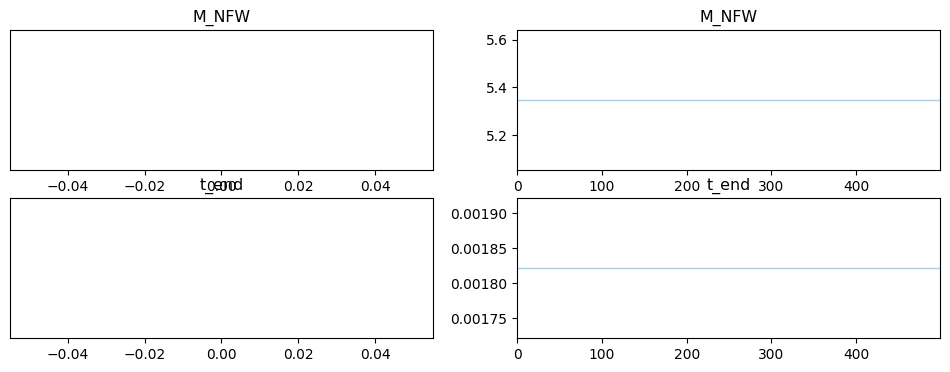

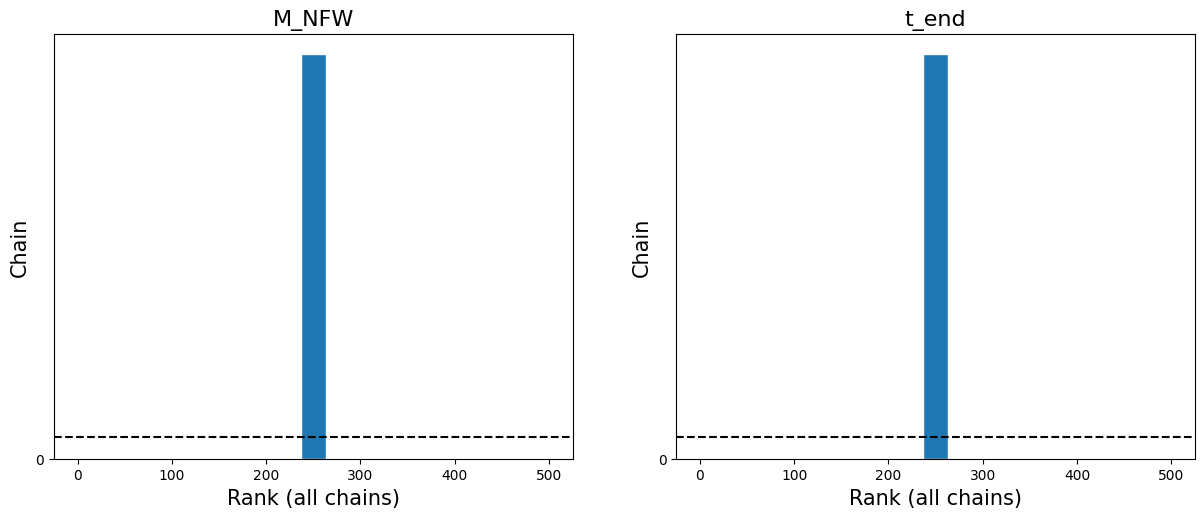

/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


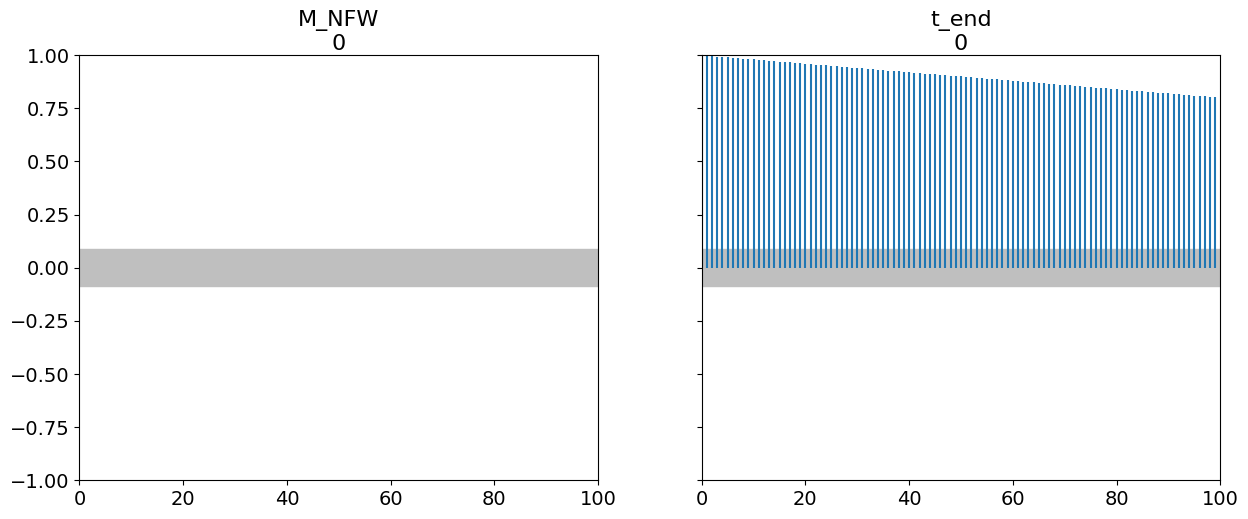

/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/arviz/stats/density_utils.py:826: RuntimeWarning: invalid value encountered in divide
  xyi /= [d_x, d_y]


ValueError: arange: cannot compute length

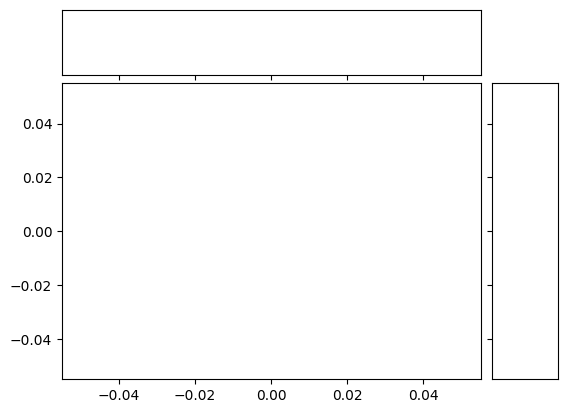

In [1]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Load samples
data = np.load('./NUTS_newlikelihood/samples.npz')

# Put into InferenceData object
idata = az.from_dict(
    posterior={
        "M_NFW": data["M_NFW"],   # add chain dim
        "t_end": data["t_end"]
    }
)

# 🔹 Summary statistics (mean, sd, ess, R-hat)
print(az.summary(idata))

# 🔹 Trace plots
az.plot_trace(idata)
plt.show()

# 🔹 Rank plots (good for diagnosing divergences)
az.plot_rank(idata)
plt.show()

# 🔹 Posterior KDEs
az.plot_posterior(idata)
plt.show()

# 🔹 Autocorrelation
az.plot_autocorr(idata)
plt.show()

# 🔹 Joint posterior density
az.plot_pair(idata, kind="kde", marginals=True)
plt.show()
